File open
number_of_games: 1000 min_eval: -81.02 max_eval: 129.23
number_of_games: 2000 min_eval: -87.95 max_eval: 143.12
number_of_games: 3000 min_eval: -112.15 max_eval: 143.12
number_of_games: 4000 min_eval: -112.15 max_eval: 143.12
number_of_games: 5000 min_eval: -112.15 max_eval: 143.12
number_of_games: 6000 min_eval: -141.27 max_eval: 143.12
number_of_games: 7000 min_eval: -141.27 max_eval: 143.12
number_of_games: 8000 min_eval: -141.27 max_eval: 143.12
number_of_games: 9000 min_eval: -147.94 max_eval: 150.81
number_of_games: 10000 min_eval: -147.94 max_eval: 150.81
number_of_games: 11000 min_eval: -147.94 max_eval: 150.81
number_of_games: 12000 min_eval: -147.94 max_eval: 150.81
number_of_games: 13000 min_eval: -147.94 max_eval: 150.81
number_of_games: 14000 min_eval: -147.94 max_eval: 150.81
number_of_games: 15000 min_eval: -147.94 max_eval: 150.81
number_of_games: 16000 min_eval: -147.94 max_eval: 150.81
number_of_games: 17000 min_eval: -147.94 max_eval: 150.81
number_of_games

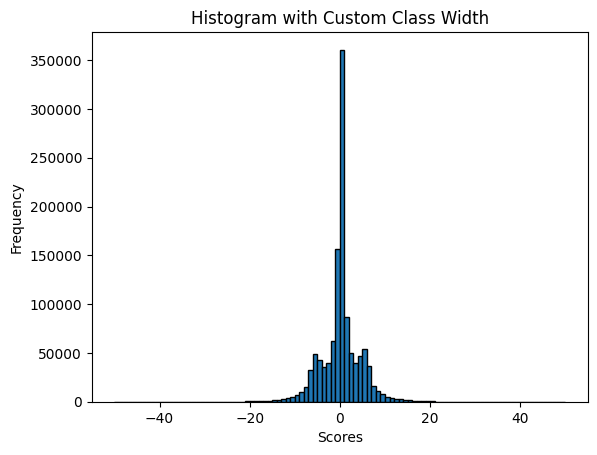

In [18]:
import chess
import chess.pgn
import io
import zstandard as zstd
import re

number_of_games = 0
display_every = 1000
max_eval = -16
min_eval = 16
with open('./data/lichess_db_standard_rated_2023-06.pgn.zst', 'rb') as f:
    dctx = zstd.ZstdDecompressor()
    reader = dctx.stream_reader(f)
    text_stream = io.TextIOWrapper(reader, encoding='utf-8')

    print("File open")

    import numpy as np
    class_width = 1
    bins = np.arange(-50, 50 + class_width, class_width)
    hist_values = np.zeros_like(bins[:-1])

    # Iterate over all games in the PGN file
    while True:
        game = chess.pgn.read_game(text_stream)
        if game is None:
            print("No game found!!!")
            break

        # Check if the game has embedded Stockfish evaluations
        has_evaluations = any('[%eval ' in node.comment for node in game.mainline())
        if not has_evaluations:
            #print("found game with no eval")
            continue

        # Iterate through all moves of the game
        scores = []
        for node in game.mainline():
            # Get the comment (which contains the evaluation) for this move
            comment = node.comment
            match = re.search(r"\[%eval (.*?)\]", comment)
            if match is None:
                #print(f"did not find a match when one was expected.")
                continue
            
            score_str = match.group(1)
            
            # Convert mate in 'n' moves to large scores
            if '#' in score_str:
                if '-' in score_str:
                    score = -200 # <--- this should be -16
                else:
                    score = +200 # <--- this should be +16
            else:
                score = float(score_str)
                scores.append(score)
                max_eval = max(score, max_eval)
                min_eval = min(score, min_eval)
        hist, _ = np.histogram(scores, bins=bins)
        hist_values += hist
    
        number_of_games += 1
        if number_of_games % display_every == 0:
            print(f"number_of_games: {number_of_games} min_eval: {min_eval} max_eval: {max_eval}")

        if number_of_games == 20000:
            break
    
import pandas as pd
import matplotlib.pyplot as plt
# Plot the histogram
plt.hist(bins[:-1], bins=bins, weights=hist_values, edgecolor='black')
plt.xlabel('Scores')
plt.ylabel('Frequency')
plt.title('Histogram with Custom Class Width')
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define file path and class width
file_path = 'path/to/yourfile.csv'
class_width = 10

# Define the histogram bins (you can set the range according to your data)
bins = np.arange(0, 100 + class_width, class_width)
hist_values = np.zeros_like(bins[:-1])

# Read file in chunks and update the histogram
chunksize = 10**5  # Adjust this according to your available memory
for chunk in pd.read_csv(file_path, chunksize=chunksize):
    # Assume the column you want to plot is named 'Value'
    values = chunk['Value']
    hist, _ = np.histogram(values, bins=bins)
    hist_values += hist

# Plot the histogram
plt.hist(bins[:-1], bins=bins, weights=hist_values, edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram with Custom Class Width')
plt.show()